# Investigation of OpenFF types using MACE

MACE can classify atomic environments using 3D information. The goal is to establish if it is possible to expand on existing (human curated) OpenFF types in a useful way?

This notebook first processes a small dataset and assigns OpenFF types, then embeds the same dataset using mace MACE. UMAP is then applied to these embeddings to create a 2D similarity plot, which is then clustered using HDBscan.

### Questions

- Does MACE find new types? i.e. Are there seperate UMAP clusters for the same OpenFF type (colour)?
- Are these types conformer independent? i.e. Are any atoms present in more than one UMAP cluster?

In [32]:
from openff.toolkit import ForceField, Molecule, Topology
from ase import Atoms
from ase.io import write
import numpy as np
from tqdm import tqdm

from umap import UMAP

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import rdkit
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import hdbscan


# np.set_printoptions(threshold=np.inf, linewidth=10000)

### Assigning OpenFF types

In [33]:
# originally wiht openff 2.0.0
forcefield = ForceField("openff-2.0.0.offxml")
with open('smiles-train-filtered.txt', 'r') as file:
    lines = file.readlines()
smiles_list = np.array([line.strip() for line in lines])

In [34]:
# writes out each conformer with 3D coords and assigned atom types

# db = []
# for smile in tqdm(smiles_list):
#     print(smile)
#     molecule = Molecule.from_smiles(smile, allow_undefined_stereo=True)
#     molecule.generate_conformers()
#     atom_indices = [i for i in range(len(molecule._atoms))]
    
#     numbers = [at._atomic_number for at in molecule._atoms]
#     positions = molecule.conformers[0]
#     atom = Atoms(numbers=numbers, positions=positions)
 
#     topology = Topology.from_molecules([molecule])
#     force_list = forcefield.label_molecules(topology)
#     atom.arrays['atom_types'] = np.array([param.id for idx, param in force_list[0]['vdW'].items()])
#     atom.arrays['atom_indices'] = np.array(atom_indices)
#     db += [atom]
    
# write('test.xyz', db)

In [35]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom

from tqdm import tqdm
from openff.units import unit

#multiple embeddings for a single mol
db = []
forcefield = ForceField("openff-2.0.0.offxml")
#smiles_list = ['ClCCCCCO', 'BrCCCC=O', 'IC#CCO', 'CC(O)CN']

#read in dataset.smi and read each line and add to smiles_list
with open('dataset.smi', 'r') as file:
    smiles_list = [line.strip() for line in file.readlines()]


smiles_list = smiles_list[:50]

def label_conformers(smiles, n_conformers=100, rms_cutoff=0.05):
    """
    Generate and label conformers for a given SMILES string.
    
    Parameters:
    -----------
    smiles : str
        SMILES string of the molecule
    n_conformers : int
        Number of conformers to generate
    rms_cutoff : float
        RMS cutoff for conformer pruning in Angstroms
    
    Returns:
    --------
    list
        List of ASE Atoms objects, each containing a conformer with labels
    """
    from openff.toolkit import ForceField, Molecule, Topology
    from openff.units import unit
    from ase import Atoms
    
    # Initialize force field and database
    forcefield = ForceField("openff-2.0.0.offxml")
    db = []
    
    # Generate molecule and conformers
    molecule = Molecule.from_smiles(smiles, allow_undefined_stereo=True)
    molecule.generate_conformers(
        n_conformers=n_conformers, 
        rms_cutoff=rms_cutoff * unit.angstrom
    )
    
    # Get atomic information (same for all conformers)
    numbers = [at._atomic_number for at in molecule._atoms]
    atom_indices = list(range(len(molecule._atoms)))
    topology = Topology.from_molecules([molecule])
    force_list = forcefield.label_molecules(topology)
    atom_types = np.array([param.id for idx, param in force_list[0]['vdW'].items()])
    
    # Process each conformer
    for i in range(molecule.n_conformers):
        positions = molecule.conformers[i]
        atom = Atoms(numbers=numbers, positions=positions)
        atom.arrays['atom_types'] = atom_types
        atom.arrays['atom_indices'] = np.array(atom_indices)
        db.append(atom)
    
    return (smiles, db)




### Embedding via MACE

In [36]:
from mace.calculators import mace_mp
import warnings
warnings.filterwarnings("ignore")

def mace_featurise(db, num_layers=1):
    """
    Generate MACE descriptors for a list of atomic structures.
    
    Parameters:
    -----------
    db : list
        List of ASE Atoms objects
    num_layers : int
        Number of message passing layers to use
        
    Returns:
    --------
    np.ndarray
        Array of MACE descriptors, shape (n_atoms_total, n_features)
    """
    from mace.calculators import mace_mp
    import warnings
    warnings.filterwarnings("ignore")
    
    # Initialize MACE calculator
    mace = mace_mp()
    
    # Generate descriptors
    desc_col = []
    for at in tqdm(db, desc="Generating MACE descriptors"):
        desc_col.append(mace.get_descriptors(at, num_layers=num_layers))
    
    # Concatenate all descriptors
    return np.concatenate(desc_col, axis=0)



In [37]:
descs_list = []
db_list = []
for smi in smiles_list:
    db = label_conformers(smi)
    db_list.append(db)
    descs = mace_featurise(db[1])
    descs_list.append(descs)
    

descs = np.concatenate(descs_list, axis=0)

Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 1/1 [00:00<00:00, 25.56it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 4/4 [00:00<00:00, 29.33it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 3/3 [00:00<00:00, 24.73it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 100/100 [00:01<00:00, 57.23it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 1/1 [00:00<00:00, 26.18it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 2/2 [00:00<00:00, 22.15it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 7/7 [00:00<00:00, 37.90it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 9/9 [00:00<00:00, 40.93it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 5/5 [00:00<00:00, 32.27it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 6/6 [00:00<00:00, 35.09it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 5/5 [00:00<00:00, 32.92it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 5/5 [00:00<00:00, 33.02it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 3/3 [00:00<00:00, 25.27it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 6/6 [00:00<00:00, 27.59it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 5/5 [00:00<00:00, 32.74it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 3/3 [00:00<00:00, 25.14it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 4/4 [00:00<00:00, 29.08it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 2/2 [00:00<00:00, 22.25it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 3/3 [00:00<00:00, 25.52it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 4/4 [00:00<00:00, 28.68it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 4/4 [00:00<00:00, 28.99it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 77/77 [00:01<00:00, 60.01it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 6/6 [00:00<00:00, 35.99it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 4/4 [00:00<00:00, 28.99it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 4/4 [00:00<00:00, 29.68it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 2/2 [00:00<00:00, 22.69it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 3/3 [00:00<00:00, 25.37it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 5/5 [00:00<00:00, 32.71it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 3/3 [00:00<00:00, 21.25it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 7/7 [00:00<00:00, 37.03it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 3/3 [00:00<00:00, 24.79it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 8/8 [00:00<00:00, 39.67it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 2/2 [00:00<00:00, 21.96it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 5/5 [00:00<00:00, 31.10it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 2/2 [00:00<00:00, 20.95it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 4/4 [00:00<00:00, 29.28it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 3/3 [00:00<00:00, 24.43it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 3/3 [00:00<00:00, 25.38it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 3/3 [00:00<00:00, 24.89it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 8/8 [00:00<00:00, 40.20it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 2/2 [00:00<00:00, 22.20it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 1/1 [00:00<00:00, 25.65it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 15/15 [00:00<00:00, 47.42it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 32/32 [00:00<00:00, 54.51it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 31/31 [00:00<00:00, 53.95it/s]


Using Materials Project MACE for MACECalculator with /home/cree/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


Generating MACE descriptors: 100%|██████████| 14/14 [00:00<00:00, 47.18it/s]


### Dimensionality reduction of MACE embeddings using UMAP

In [38]:
reducer = UMAP(n_neighbors=50, min_dist=0.5, n_components=2, random_state=0xDEAD)
descs_reduced = reducer.fit_transform(descs)

#%store -r descs_reduced


In [39]:
def get_atom_types(db_list):
    """
    Extract unique atom types from a list of (SMILES, conformers) pairs.
    
    Parameters:
    -----------
    db_list : list
        List of tuples (SMILES, conformers)
        
    Returns:
    --------
    dict
        Mapping of atom types to numeric labels
    list
        List of numeric labels for all atoms
    """
    # Get all atom types from all molecules
    types_list = []
    labels_list = []
    for db in db_list:
        types = [l for at in db[1] for l in at.arrays['atom_types']]
        types_list.extend(types)

    types2labels = {t: l for l, t in enumerate(set(types_list))}
    labels = [types2labels[t] for t in types_list]

    
    return types2labels, labels

types2labels, labels = get_atom_types(db_list)
types2labels


{'n4': 0,
 'n2': 1,
 'n6': 2,
 'n20': 3,
 'n8': 4,
 'n19': 5,
 'n17': 6,
 'n14': 7,
 'n3': 8,
 'n12': 9,
 'n11': 10,
 'n16': 11,
 'n25': 12,
 'n24': 13,
 'n21': 14,
 'n18': 15}

### UMAP Plot

Number of points in UMAP: 7670


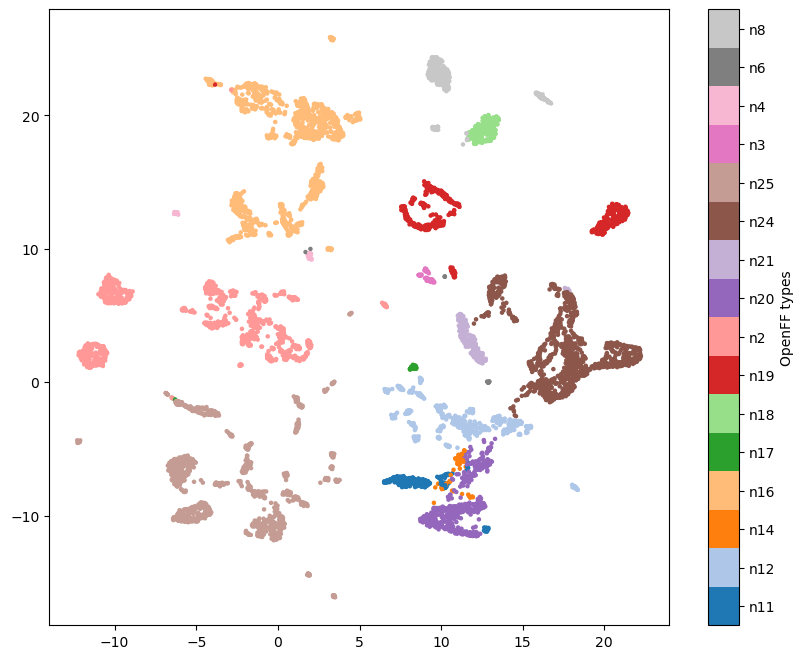

In [40]:
# Coloured by OPENFF atom type
tab20 = cm.get_cmap('tab20')
custom_cmap = tab20.colors[:len(types2labels)]

print(f"Number of points in UMAP: {descs_reduced.shape[0]}")


plt.figure(figsize=(10, 8))
h = plt.scatter(descs_reduced[:,0], descs_reduced[:,1], s=5, c=labels, cmap=ListedColormap(custom_cmap))
cbar = plt.colorbar(h, ticks = range(len(types2labels)), label='OpenFF types')
plt.clim(-0.5, len(types2labels) - 0.5)
unique_types = sorted(types2labels.keys())
cbar.set_ticklabels(unique_types)


### Cluster Analysis

In [41]:

# needed for hover in interactive bokeh plot
def smi2svg(smi):
    mol = Chem.MolFromSmarts(smi)
    AllChem.Compute2DCoords(mol)
    
    d2d = Draw.rdMolDraw2D.MolDraw2DSVG(800, 400)
    d2d.drawOptions().addAtomIndices = True
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

# creates the final data df, which is used by bokeh to generate the interactive plot
def create_df(db, descs_reduced):
    all_smiles = []
    all_atom_ids = []
    all_descs = []
    all_atom_types = []
    all_mol_idx = []
    
    # for each mol
    for mol_idx, atoms in enumerate(db[1]):
        mol_smiles = db[0]  
        atom_indices = atoms.arrays['atom_indices']  
        atom_types = atoms.arrays['atom_types']  
        
        # entry for each atom in this molecule
        for atom_idx in range(len(atom_indices)):
            all_smiles.append(mol_smiles)
            all_atom_ids.append(atom_indices[atom_idx])
            all_descs.append(descs_reduced[len(all_descs)])
            all_atom_types.append(atom_types[atom_idx])
            all_mol_idx.append(mol_idx)
    
    df = pd.DataFrame({
        'Smiles': all_smiles,
        'mol_idx': all_mol_idx,
        'atom_id': all_atom_ids,
        'x': [desc[0] for desc in all_descs],
        'y': [desc[1] for desc in all_descs],
        'atom_types': all_atom_types
    })
    

    # hyperparams arbitrary
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=10,  
        min_samples=5,        
        metric='euclidean'
    )

    coords = df[['x', 'y']].values
    df['cluster_id'] = clusterer.fit_predict(coords)
    
    return df

dfs = []
for db in db_list:
    df = create_df(db, descs_reduced)
    dfs.append(df)

df = pd.concat(dfs)
df.head()

,Smiles,mol_idx,atom_id,x,y,atom_types,cluster_id
0,[NH3+]C12C3C4C1C1C2C3C41[NH3+],0,0,-3.932169,22.451443,n20,-1
1,[NH3+]C12C3C4C1C1C2C3C41[NH3+],0,1,-6.441707,-1.211391,n16,-1
2,[NH3+]C12C3C4C1C1C2C3C41[NH3+],0,2,-6.783334,-0.895365,n16,-1
3,[NH3+]C12C3C4C1C1C2C3C41[NH3+],0,3,-6.777421,-0.892478,n16,-1
4,[NH3+]C12C3C4C1C1C2C3C41[NH3+],0,4,-6.784262,-0.892389,n16,-1


In [42]:

def check_cluster_consistency(df):
    """
    Check if atoms get assigned to different clusters across conformers of the same molecule.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with columns: Smiles, mol_idx, atom_id, cluster_id
        
    Returns:
    --------
    pd.DataFrame
        DataFrame showing atoms with inconsistent cluster assignments
    """
    # Group by SMILES and atom_id, get unique cluster assignments
    inconsistent = df.groupby(['Smiles', 'atom_id'])['cluster_id'].agg(
        unique_clusters=lambda x: list(set(x)),
        num_clusters=lambda x: len(set(x))
    )
    
    # Filter for atoms that appear in multiple clusters
    inconsistent = inconsistent[inconsistent['num_clusters'] > 1]
    
    if len(inconsistent) > 0:
        # Count unique atom_ids with multiple clusters
        unique_atom_ids = inconsistent.index.get_level_values('atom_id').nunique()
        print(f"\nSummary:")
        print(f"Number of unique atom IDs with multiple clusters: {unique_atom_ids}")
        print(f"Total inconsistent assignments: {len(inconsistent)}")
        
        # Get distribution of number of clusters per atom
        cluster_counts = inconsistent['num_clusters'].value_counts().sort_index()
        print("\nDistribution of clusters per atom:")
        for n_clusters, count in cluster_counts.items():
            print(f"Atoms appearing in {n_clusters} clusters: {count}")
            
        # Optional: show some examples
        print("\nExample cases:")
        for (smiles, atom_id), row in inconsistent.head().iterrows():
            print(f"\nSMILES: {smiles}")
            print(f"Atom ID: {atom_id}")
            print(f"Appears in clusters: {row['unique_clusters']}")
    else:
        print("All atoms are consistently clustered across conformers")
    
    return inconsistent

inconsistent = check_cluster_consistency(df)


Summary:
Number of unique atom IDs with multiple clusters: 25
Total inconsistent assignments: 701

Distribution of clusters per atom:
Atoms appearing in 2 clusters: 271
Atoms appearing in 3 clusters: 133
Atoms appearing in 4 clusters: 84
Atoms appearing in 5 clusters: 74
Atoms appearing in 6 clusters: 25
Atoms appearing in 7 clusters: 4
Atoms appearing in 8 clusters: 10
Atoms appearing in 9 clusters: 20
Atoms appearing in 10 clusters: 13
Atoms appearing in 11 clusters: 8
Atoms appearing in 12 clusters: 13
Atoms appearing in 13 clusters: 20
Atoms appearing in 14 clusters: 8
Atoms appearing in 15 clusters: 5
Atoms appearing in 16 clusters: 9
Atoms appearing in 17 clusters: 2
Atoms appearing in 18 clusters: 2

Example cases:

SMILES: Brc1nc2nc(Br)c(Br)nc2[nH]1
Atom ID: 0
Appears in clusters: [0, 1, 2, 4]

SMILES: Brc1nc2nc(Br)c(Br)nc2[nH]1
Atom ID: 1
Appears in clusters: [0, 1, 2, 3, 4, -1]

SMILES: Brc1nc2nc(Br)c(Br)nc2[nH]1
Atom ID: 2
Appears in clusters: [1, 2, 3, 4, -1]

SMILES: Brc1

In [43]:
# Some mols have the same atom assigned to different clusters, and so the MACE embedding is not conformer independent, as expected
# Perhaps try a larger and more varied dataset and see if that fixes it

# example mol with an atom assigned to different clusters, x & y coords are very different so not just a clustering artifact
# does assume UMAP has correctly reduced the embedding, though
df[(df['Smiles'] == 'Nc1nc2[nH]c(O)nc2c(=O)[nH]1') & (df['atom_id'] == 1)]

,Smiles,mol_idx,atom_id,x,y,atom_types,cluster_id
1,Nc1nc2[nH]c(O)nc2c(=O)[nH]1,0,1,-6.441707,-1.211391,n14,2
18,Nc1nc2[nH]c(O)nc2c(=O)[nH]1,1,1,14.755436,-3.936475,n14,4
35,Nc1nc2[nH]c(O)nc2c(=O)[nH]1,2,1,15.292462,-3.766339,n14,4
52,Nc1nc2[nH]c(O)nc2c(=O)[nH]1,3,1,9.765222,18.930138,n14,0
69,Nc1nc2[nH]c(O)nc2c(=O)[nH]1,4,1,0.469430,-6.907601,n14,1


In [44]:
# Save df
df.to_csv('clustered_dataset.csv')

### Generate Interactive UMAP Plot

In [49]:


def plot_umap_atoms_colored(df, filename=None):
    """
    Create an interactive UMAP plot with points colored by MACE atom type.
    """
    from bokeh.models import ColorBar, LinearColorMapper, ColumnDataSource
    from bokeh.transform import factor_cmap
    from bokeh.palettes import Spectral10, Category20
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.io import output_file
    
    # svg representations of molecules
    df['svg'] = df['Smiles'].apply(lambda x: smi2svg(x))
    
    
    atom_types = sorted(df['atom_types'].unique())
    
    
    color_map = factor_cmap(
        'atom_types',           
        Category20[20],            
        atom_types             
    )
    
    # prepare data for Bokeh
    source = ColumnDataSource(df)
    
    # hover tooltip
    TOOLTIPS = """
    <div>
        @{svg}{safe}
        <br>
        Molecule ID: @mol_idx
        <br>
        Atom ID: @atom_id
        <br>
        Atom Type: @atom_types
    </div>
    """
    
    
    p = figure(width=1000, height=600, 
              title="UMAP Projection of Atom Descriptors",
              tooltips=TOOLTIPS)
    
    
    p.circle('x', 'y', size=5, source=source, 
            color=color_map, alpha=0.6)
        
    if filename:
        output_file(filename)
        show(p)
    else:
        
        output_notebook()
        show(p)

# coloured by MACE atom types, saves a .html of the plot (and potentially automaticaly opens in your default browser)
plot_umap_atoms_colored(df, filename='umap.html')



In [46]:
# raw data, cluster_id -1 means unassigned
df

,Smiles,mol_idx,atom_id,x,y,atom_types,cluster_id,svg
0,[NH3+]C12C3C4C1C1C2C3C41[NH3+],0,0,-3.932169,22.451443,n20,-1,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
1,[NH3+]C12C3C4C1C1C2C3C41[NH3+],0,1,-6.441707,-1.211391,n16,-1,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
2,[NH3+]C12C3C4C1C1C2C3C41[NH3+],0,2,-6.783334,-0.895365,n16,-1,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
3,[NH3+]C12C3C4C1C1C2C3C41[NH3+],0,3,-6.777421,-0.892478,n16,-1,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
4,[NH3+]C12C3C4C1C1C2C3C41[NH3+],0,4,-6.784262,-0.892389,n16,-1,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
...,...,...,...,...,...,...,...,...
261,O=Cc1[nH]nc2c1CC1CC21,13,14,0.781545,-8.260488,n2,6,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
262,O=Cc1[nH]nc2c1CC1CC21,13,15,4.842766,19.630127,n2,2,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
263,O=Cc1[nH]nc2c1CC1CC21,13,16,0.734479,-8.303406,n2,6,<?xml version='1.0' encoding='iso-8859-1'?>\n<...
264,O=Cc1[nH]nc2c1CC1CC21,13,17,4.916242,19.828884,n2,2,<?xml version='1.0' encoding='iso-8859-1'?>\n<...


Gtk-Message: 21:50:01.913: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[22506, Main Thread] WARNING: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox:22506): Gtk-WARNING **: 21:50:01.965: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 21:50:01.965: Failed to load module "canberra-gtk-module"
[22506, Main Thread] WARNING: GTK+ module /snap/firefox/5647/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process